In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.cluster import KMeans

In [134]:
def moments(row):
    idade = row['idade']
    renda_mensal = row['renda_mensal']
    investimento_total = row['investimento_total']
    
    if 0 <= idade < 16:
        return 'Momento 1'
    elif 16 <= idade < 26:
        return 'Momento 2'
    elif 26 <= idade < 60:
        if renda_mensal >= 5e3:
            if investimento_total < 2e5:
                return 'Momento 6'
            else:
                return 'Momento 7'
        elif (idade < 36) and (renda_mensal < 5e3):
            return 'Momento 3'
        elif (idade < 45) and (renda_mensal < 5e3):
            return 'Momento 4'
        elif renda_mensal < 5e3:
            return 'Momento 5'
    elif idade >= 60:
        if renda_mensal < 5e3:
            return 'Momento 8'
        else:
            return 'Momento 9'

def wage_cat(data):
    
    qt_30 = data['renda_mensal'].quantile(.3)
    qt_70 = data['renda_mensal'].quantile(.7)
    qt_90 = data['renda_mensal'].quantile(.9)

    return data\
        .assign(
            categoria_renda=lambda x: (
                x\
                    .renda_mensal\
                    .apply(
                        lambda renda: (
                            'BAIXISSIMA' if renda <= qt_30 else
                            'CLASSE MÉDIA - NORMAL' if renda <= qt_70 else
                            'CLASSE MÉDIA - ALTA' if renda <= qt_90 else
                            'ALTA RENDA'
                    )
                )
            )
        )

In [3]:
df = pd.read_csv(
    'ldw-base_relacionamento_atual.csv',
    delimiter=';',
    dtype={'cod_carteira': str}
    )\
    .astype(
        {
            'cod_central': str,
            'cod_coop': str,
            'num_conta_principal': str,
            'cod_ua': str,
            'num_cpf_cnpj': str,
            'cod_cnae': str,
            'ano_mes': str,
            'flg_cheque_especial': str,
            'num_ano_mes': str,
            'flg_associado': str,
            'digital_acessou_30d': int,
            'mobi_acessou_30d': int
        }
    )\
    .assign(
        cad_pix=lambda x: x.cad_pix.map({'S': 1, 'N': 0}),
        assoc_desde=lambda x: pd.to_datetime(x.assoc_desde),
        tempo_assoc=lambda x: (pd.Timestamp('2024-11-01') - x.assoc_desde).dt.days,
        ultimo_contato=lambda x: pd.to_datetime(x.ultimo_contato),
        nivel_risco=lambda x: x.nivel_risco.fillna('DEFAULT'),
        score_principalidade=lambda x: x.score_principalidade.fillna(0),
        faixa_principalidade=lambda x: x.faixa_principalidade.replace('MISSING', np.nan).fillna('BAIXA'),
        desc_cbo=lambda x: x.desc_cbo.replace('ESTUDANTE', 'Estudantes'),
        publico_estrategico=lambda x: x.publico_estrategico.fillna('cooperativa'),
        investimento_total=lambda x: x.sld_lci + x.sld_lca + x.sld_fundos + x.sld_dep_a_prazo,
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1),
        flg_sexo=lambda x: [
            'PJ' if x.segmento.loc[i] == "PJ"
            else x.flg_sexo.loc[i]
            for i in range(x.shape[0])
        ],
    )\
    .query(
        '(status_associado == "ATIVO") '
        'and ~renda_mensal.isna() '
        'and (segmento != "AG")'
    )\
    .drop(
        columns=[
            'sld_cred_scr_180_2m', 'sld_cred_sicredi_sas_2m',
            'sld_cred_sicredi_sas_180_2m', 'mc_seguro_agricola',
            'vlr_prej_coobrigacoes', 'vlr_prej_outros', 'sld_cred_moeda',
            'sld_seg_elementares', 'sld_seg_agricola', 'fat_ano',
            'mc_seg_elementares', 'mc_domicilio', 'mc_cred_moeda',
            'qt_cred_moeda', 'qt_seg_elementares', 'qt_seg_agricola',
            'vlr_prej_cred_rural', 'mc_seguro_rural'
        ]
    )\
    .dropna(subset=['idade'])\
    .reset_index(drop=True)
        

df = df\
    .astype(
        {
            col: str
            for col in df.loc[:,df.columns.str.startswith(
                ('prod', 'flg', 'digital',
                 'possui', 'ib', 'mobi', 'fone')
            )].columns
        }
    )\
    .assign(
        qt_investimento_media=lambda x: x.loc[:, [
            'qt_fundos', 'qt_lci', 'qt_lca',
            'qt_dep_a_prazo']].mean(axis=1)
    )

df.loc[
    (df.idade <= 15) &
    (df.renda_mensal >= 0),
    'renda_mensal'] = 0

df.loc[
    (df.idade >= 16) &
    (df.renda_mensal < 1000) &
    (~df.desc_cbo.isin(['Estudantes'])),
    'renda_mensal'] = np.nan

df.loc[
    (df.idade >= 18) &
    (df.renda_mensal < 1000) &
    df.desc_cbo.isin(['Estudantes']),
    'renda_mensal'] = df.sld_cred_scr_2m * .3

df.loc[
    (df.idade >= 18) &
    (df.renda_mensal < 1000) &
    df.desc_cbo.isin(['Estudantes']),
    'renda_mensal'] = np.nan

df.loc[df.renda_mensal.isna(), 'renda_mensal'] = df\
    .groupby('desc_cbo')\
    .renda_mensal\
    .transform('mean')

In [ ]:
knn = KNNImputer(n_neighbors=10)
knn_cols = df.dropna(subset=['renda_mensal'])\
    .select_dtypes(include=np.number).corr(method='spearman')\
    .renda_mensal.abs().sort_values(ascending=False).head(50).index\
    .tolist()
df_impute_knn = knn.fit_transform(df[knn_cols])
df_impute_knn = pd.DataFrame(
    df_impute_knn,
    columns=knn_cols
    )
df['renda_mensal'] = df_impute_knn.renda_mensal
df = df\
    .assign(
        momentos=lambda x: x.apply(moments, axis=1),
        alavancagem=lambda x: (x.sld_cred_scr_2m / x.renda_mensal).replace(np.inf, 0).fillna(0),
    )\
    .query('desc_cbo != "Diretor de produção e operações em empresa pesqueira"')\
    .reset_index(drop=True)

df = wage_cat(df)

#### Cooperativas Geral

In [419]:
df_cluster = df\
    .loc[:, [
        'idade', 'renda_mensal',
        'isa', 'sld_previdencia',
        'sld_inad_ca_0', 'investimento_total',
        'tempo_assoc', 'score_principalidade',
        ] +
        df.columns[df.columns.str.startswith('sld_seg')].tolist() +
        df.columns[df.columns.str.startswith('sld_cred')].tolist() +
        df.columns[df.columns.str.startswith('mc_') & ~df.columns.isin([
            'mc_assoc', 'mc_assoc_6_meses', 'mc_total'
        ])].tolist() +
        df.filter(like='vlr_prej').columns.tolist()
    ]\
    .drop(
        columns=[
            'sld_seg_patrimonial', 'sld_seg_rural',
            'sld_seg_out_familias', 'sld_cred_coobrigacoes',
            'sld_cred_direcionados', 'vlr_prej_direcionados',
            'mc_seguro_prestamista', 'mc_seguro_patrimonial',
            'sld_cred_rural', 'mc_cred_direcionados',
            'mc_folha_pgmt', 'mc_lci', 'mc_cambio',
            'mc_adq', 'mc_pagamento_fornecedor',
            'mc_cred_rural', 'mc_custodia_cheques'
        ]
    )

df_cluster_columns = df_cluster.columns.tolist()
df_cluster = pd.DataFrame(
    StandardScaler().fit_transform(df_cluster),
    columns=df_cluster_columns
    )#\
    #.assign(
    #    #idade=lambda x: 50 * x.idade,
    #)

In [420]:
class Inertia: 
    def __init__(self, data, cluster_columns=None, set_groups=20):
        self.set_groups = set_groups + 1
        self.data = data
        self.data_cluster = data.loc[:, cluster_columns]
        self.cluster_columns = cluster_columns

    def find_groups(self, n_clusters):
        return KMeans(
            n_clusters=n_clusters,
            init='k-means++',
            random_state=42
            ).fit(self.data_cluster)\
            .labels_
    
    def calc_inertia(self):
        return [
            KMeans(
                n_clusters=i,
                init='k-means++',
                random_state=42
            ).fit(self.data_cluster)\
            .labels_
            for i in range(1, self.set_groups)
        ]

    def plot_inertia(self):
        plt.figure(figsize=(10, 8))
        plt.plot(
            range(1, self.set_groups),
            self.calc_inertia(),
            marker='o', 
            linestyle='--'
        )

In [421]:
for seed in range(100):
    kmeans = KMeans(
        n_clusters=7,
        max_iter=5000,
        tol=1e-16,
        random_state=seed
        ).fit(df_cluster)
    cluster_ids, cluster_sizes = np.unique(kmeans.labels_, return_counts=True)
    print(f"Number of elements assigned to each cluster: {cluster_sizes}, {seed}")

Number of elements assigned to each cluster: [85413 20711   666     9 50319  1242     1], 0
Number of elements assigned to each cluster: [55962   126  5582   265   551 95858    17], 1
Number of elements assigned to each cluster: [84307   366  1395    76    61 49804 22352], 2
Number of elements assigned to each cluster: [84297   736   358  6022 48839 18105     4], 3
Number of elements assigned to each cluster: [104039     17  52396    400      1     75   1433], 4
Number of elements assigned to each cluster: [81826 47873  5680 22461    75   282   164], 5
Number of elements assigned to each cluster: [ 7035   603 94429   392    75 55135   692], 6
Number of elements assigned to each cluster: [ 50564 106351    686     75      6    363    316], 7
Number of elements assigned to each cluster: [104461    897  51844     75      4    396    684], 8
Number of elements assigned to each cluster: [ 5826   392    75   667 94869 56523     9], 9
Number of elements assigned to each cluster: [50493 20486 8

In [422]:
kmeans = KMeans(
    n_clusters=7,
    tol=1e-16,
    max_iter=5000,
    random_state=99
    ).fit(df_cluster)

In [423]:
df = df.assign(
    Grupos=kmeans.labels_
    )\
    .sort_values('Grupos')\
    .astype({'Grupos': str})

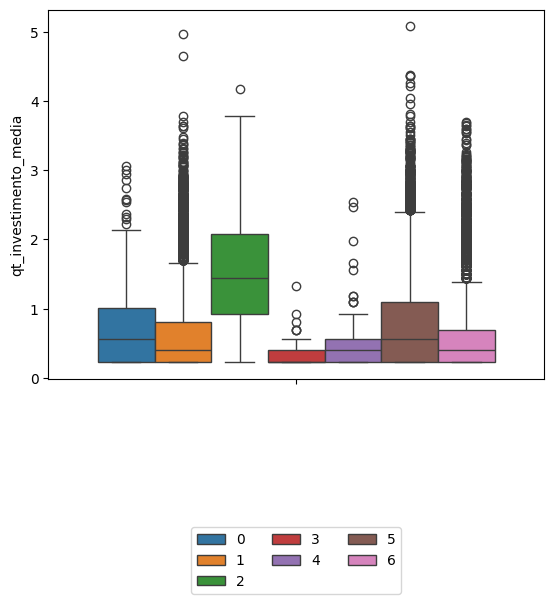

In [424]:
sns.boxplot(
    data=df\
        .assign(qt_investimento_media=lambda x: np.log1p(x.qt_investimento_media))\
        .query('qt_investimento_media != 0'),
    y='qt_investimento_media',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

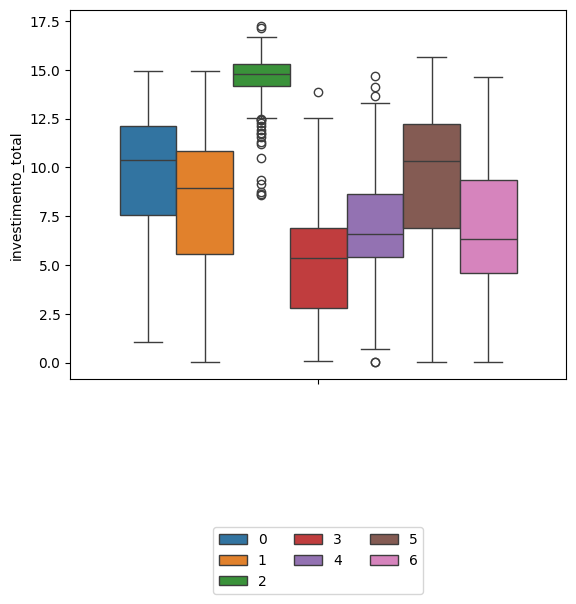

In [425]:
sns.boxplot(
    data=df\
        .assign(investimento_total=lambda x: np.log1p(x.investimento_total))\
        .query('investimento_total != 0'),
    y='investimento_total',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

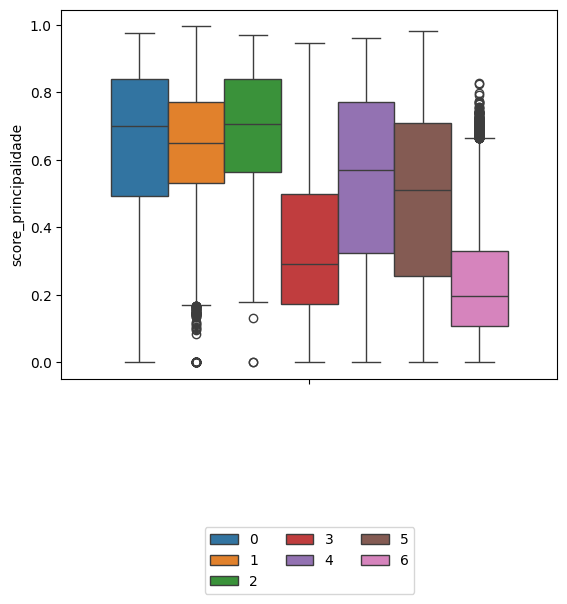

In [426]:
sns.boxplot(
    data=df\
        .assign(renda_mensal=lambda x: np.log1p(x.renda_mensal)),
    y='score_principalidade',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

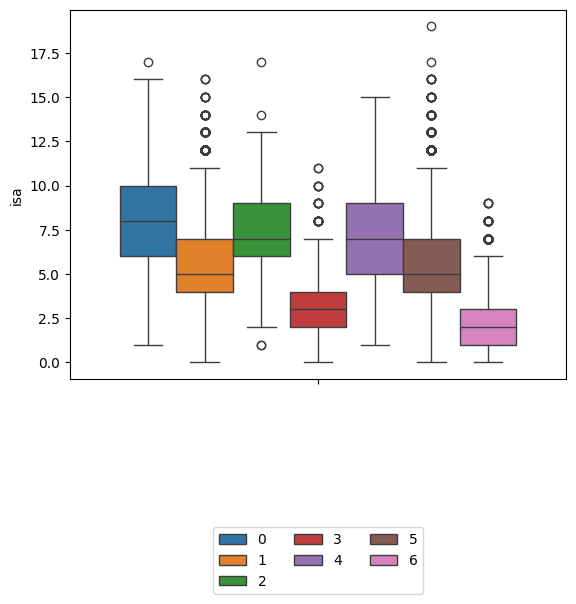

In [428]:
sns.boxplot(
    data=df\
        .assign(renda_mensal=lambda x: np.log1p(x.renda_mensal)),
    y='isa',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

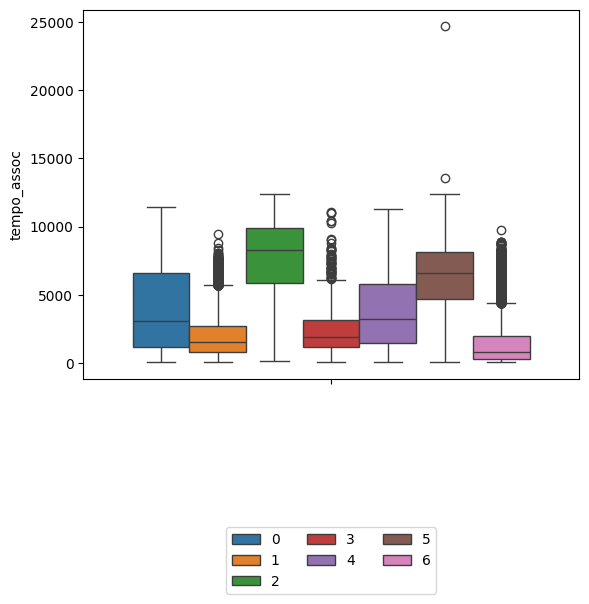

In [429]:
sns.boxplot(
    data=df,
    y='tempo_assoc',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

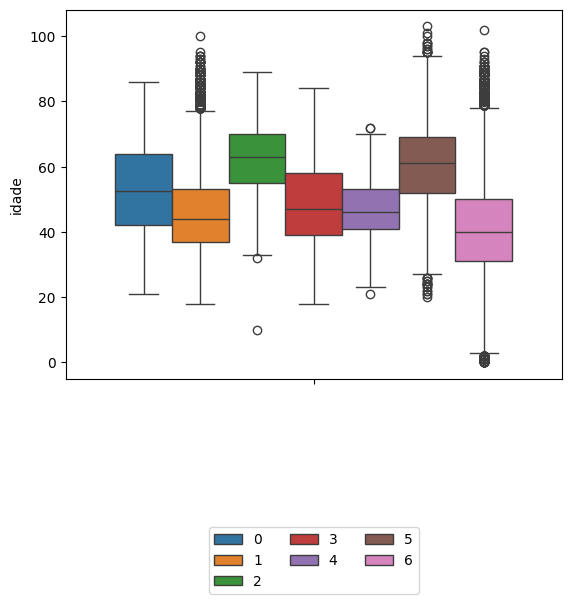

In [444]:
sns.boxplot(
    data=df,
    y='idade',
    hue='Grupos',
)
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.6), ncol=3)

<Axes: ylabel='renda_mensal'>

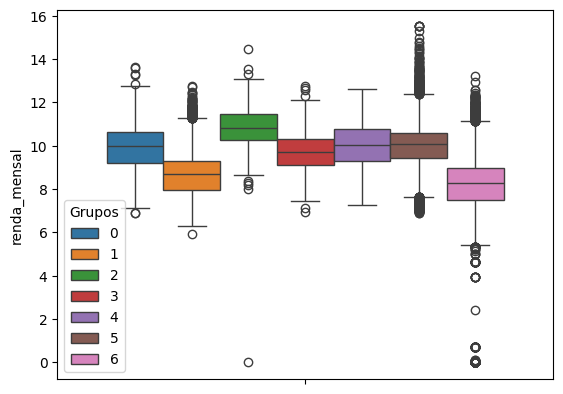

In [433]:
sns.boxplot(
    data=df\
        .assign(
            renda_mensal=lambda x: np.log1p(x.renda_mensal)
        ),
    y='renda_mensal',
    hue='Grupos'
)

In [ ]:
sns.boxplot(
    data=df\
        .assign(
            sld_fundos=lambda x: np.log1p(x.sld_fundos)
        )\
        .query('sld_lca != 0'),
    y='sld_lca',
    hue='Grupos'
)

<Axes: ylabel='sld_lci'>

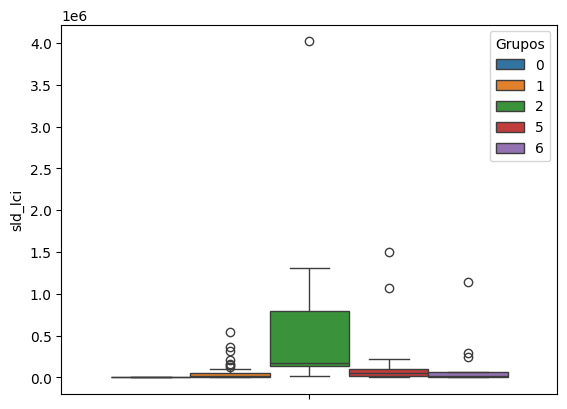

In [462]:
sns.boxplot(
    data=df\
        .assign(
            sld_fundos=lambda x: np.log1p(x.sld_fundos)
        )\
        .query('sld_lci != 0'),
    y='sld_lci',
    hue='Grupos'
)

<Axes: ylabel='sld_fundos'>

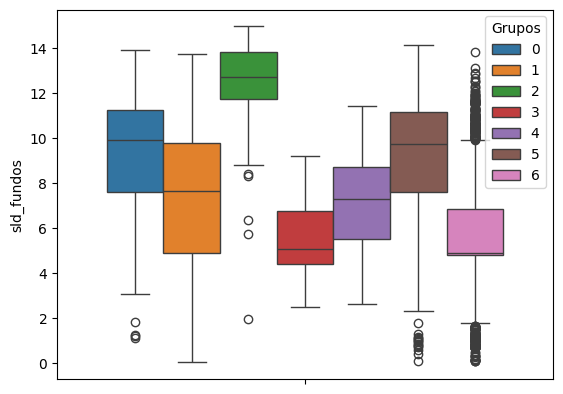

In [434]:
sns.boxplot(
    data=df\
        .assign(
            sld_fundos=lambda x: np.log1p(x.sld_fundos)
        )\
        .query('sld_fundos != 0'),
    y='sld_fundos',
    hue='Grupos'
)

<Axes: ylabel='sld_dep_a_prazo'>

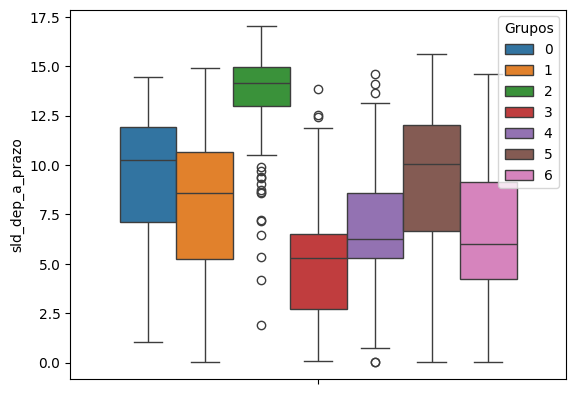

In [435]:
sns.boxplot(
    data=df\
        .assign(
            sld_dep_a_prazo=lambda x: np.log1p(x.sld_dep_a_prazo)
        )\
        .query('sld_dep_a_prazo != 0'),
    y='sld_dep_a_prazo',
    hue='Grupos'
)

<Axes: ylabel='sld_previdencia'>

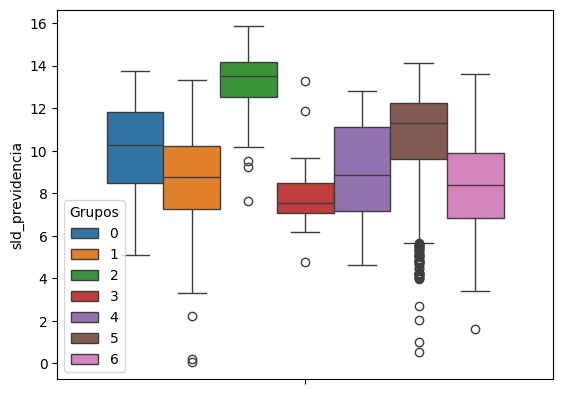

In [443]:
sns.boxplot(
    data=df\
        .assign(
            sld_previdencia=lambda x: np.log1p(x.sld_previdencia)
        )\
        .query('sld_previdencia != 0'),
    y='sld_previdencia',
    hue='Grupos'
)

<Axes: xlabel='idade', ylabel='renda_mensal'>

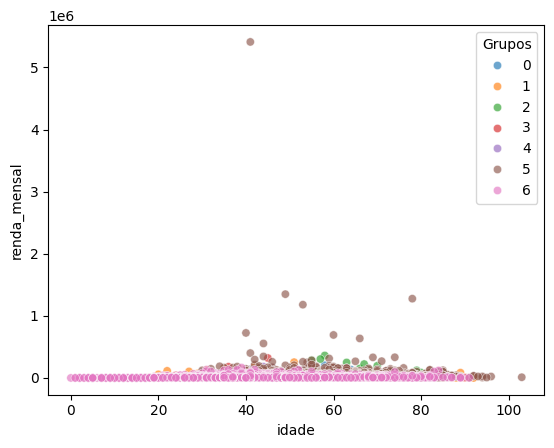

In [442]:
sns.scatterplot(
    data=df\
        .query('cod_coop == "2301"'),
    x='idade',
    y='renda_mensal',
    alpha=.65,
    hue='Grupos'
)

In [82]:
#prod_tot = df\
#    .loc[:, df.columns.str.startswith('prod_')]\
#    .stack()\
#    .reset_index(name='possui')\
#    .rename(columns={'level_1': 'produto'})\
#    .drop(columns=['level_0'])\
#    .astype({'possui': int})\
#    .groupby('produto').possui\
#    .sum().reset_index()\
#    .assign(
#        possui=lambda x: (x.possui / df.shape[0]) * 100
#    )\
#    .sort_values('possui')

In [54]:
#stack_df = df.loc[:,
#                df.columns[df.columns.str.startswith('prod_')].tolist()
#                + ['Grupos']
#            ]\
#            .set_index('Grupos')\
#            .stack()\
#            .reset_index(name='contem')\
#            .astype({'contem': int})\
#            .rename(columns={'level_1': 'produto'})\
#            .groupby(['Grupos', 'produto'])\
#            .contem\
#            .sum()\
#            .reset_index(name='total_produto_grupo')

In [418]:
df.to_csv('relacionamento_clusters.csv', index=False)